In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/ny_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2011-01-01,2231.0
2012-01-01,2694.0
2012-12-31,5283.0
2013-07-08,6.0
2013-07-16,1.0
...,...
2022-05-28,97.0
2022-05-29,39.0
2022-05-30,75.0


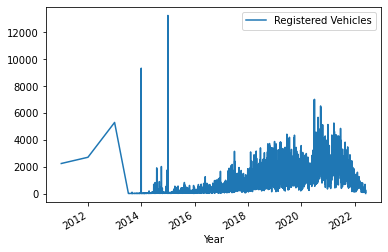

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df.plot()
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

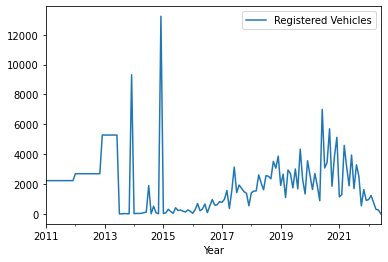

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(-4.043961866802904,
 0.0011970246968649727,
 2,
 135,
 {'1%': -3.479742586699182,
  '5%': -2.88319822181578,
  '10%': -2.578319684499314},
 2211.1378874270335)

## Modeling

In [21]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2017-06-30':'2020-12-31']
test = df['2021-06-30':]
combined = df

test

,Registered Vehicles
Year,
2021-06-30,3945.0
2021-07-31,1695.0
2021-08-31,3290.0
2021-09-30,2517.0
2021-10-31,542.0
2021-11-30,1633.0
2021-12-31,908.0
2022-01-31,964.0
2022-02-28,1234.0


In [10]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=808.099, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=764.809, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=786.108, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=753.257, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=736.453, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=737.824, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=737.706, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=743.115, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=739.639, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=733.311, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=743.523, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=733.371, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=734.284, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=743.024, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=735.4

### The best model is :  ARIMA (3,0,0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0442      0.147      0.301      0.763      -0.243       0.332
ar.L2          0.3218      0.171      1.879      0.060      -0.014       0.657
ar.L3          0.6496      0.176      3.688      0.000       0.304       0.995
sigma2      1.262e+06   2.16e+05      5.835      0.000    8.38e+05    1.69e+06


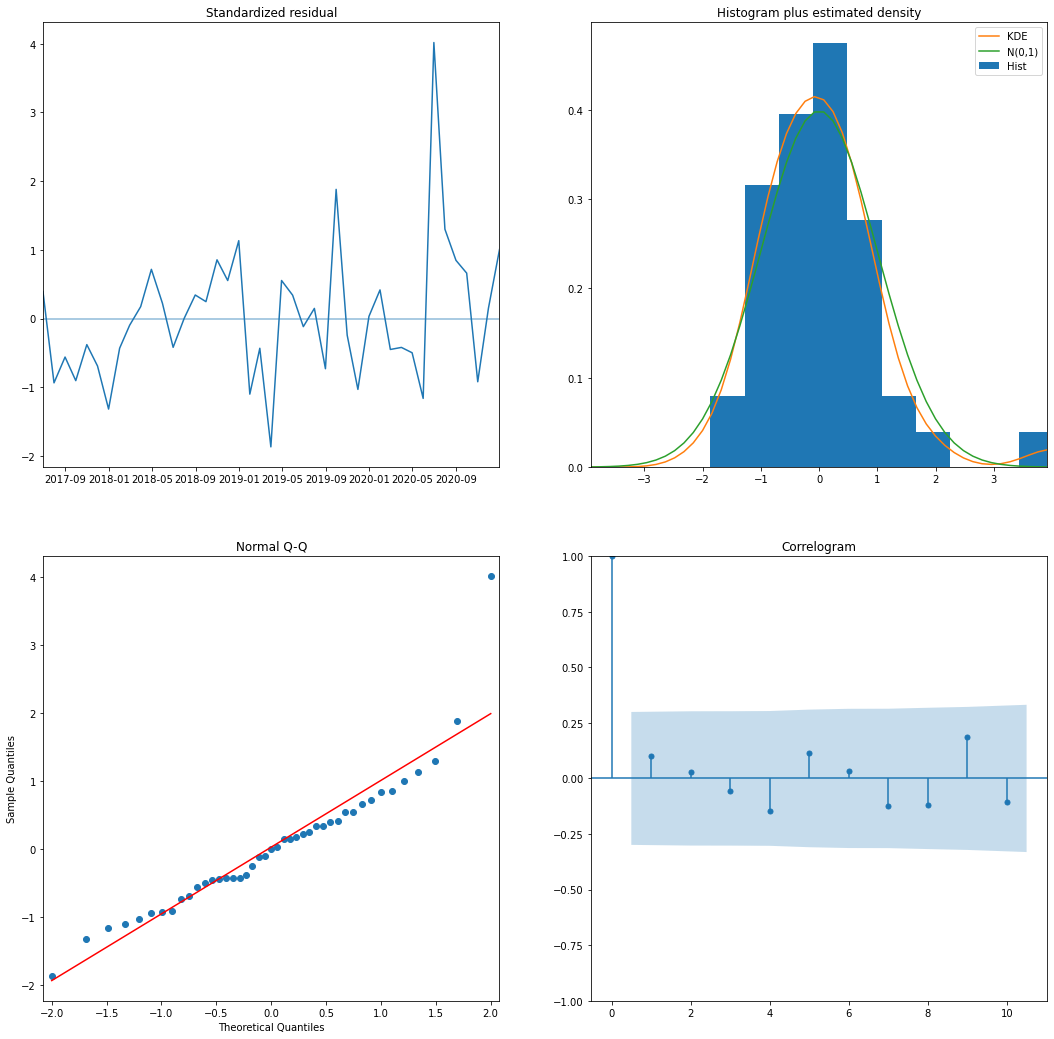

In [16]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(3,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [17]:
pred = output.get_prediction(start=pd.to_datetime('2020-12-31'), end=pd.to_datetime('2022-06-30'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2020-12-31,2266.417098,6670.794619
2021-01-31,466.910993,4871.288513
2021-02-28,2066.392028,6475.065720
2021-03-31,2063.025183,6696.526243
2021-04-30,545.154051,6057.741894
2021-05-31,1549.735327,7108.772118
2021-06-30,1158.077451,7038.956615
2021-07-31,569.325413,6867.880939
2021-08-31,1090.863725,7499.530930
2021-09-30,688.145987,7408.947947


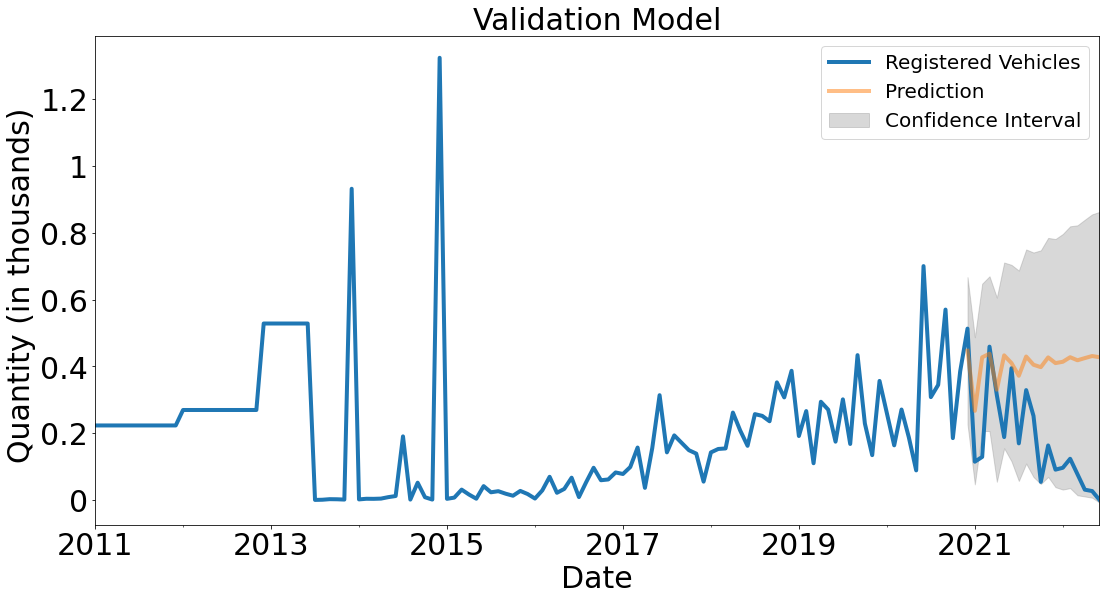

In [19]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()